Introduction: The goal of this task is to predict the intent of the customer given their query text input. The dataset is ATIS (Airline Travel Information System) and consists of (query, intent) pairs. For this problem, you will implement the Bag of Word technique and a fully connected neural network to predict the intent of query text.

In [4]:
import sklearn
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd

In [ ]:
!pip uninstall numpy
!pip install numpy
!pip uninstall gensim
!pip install gensim

In [5]:
df_train = pd.read_csv('atis.train.csv', delimiter=',')
query_train, intent_train = df_train["tokens"], df_train["intent"]

df_test = pd.read_csv('atis.test.csv', delimiter=',')
query_test, intent_test = df_test["tokens"], df_test["intent"]

In [6]:
print("Query examples: ")
query_train.head(5)
query_train.shape


Query examples: 


(4274,)

In [7]:
voc = set(words for idx in query_train.astype(str) for words in idx.split(" "))
len(voc)

874

In [8]:
print("Intent examples: ")
intent_train.head(5)

Intent examples: 


0         atis_airfare
1          atis_flight
2          atis_flight
3    atis_abbreviation
4          atis_flight
Name: intent, dtype: object

In [9]:
print("There are {:d} different categories of intent.".format(intent_train.nunique()))
print(intent_train.unique())

There are 17 different categories of intent.
['atis_airfare' 'atis_flight' 'atis_abbreviation' 'atis_ground_service'
 'atis_restriction' 'atis_airport' 'atis_quantity' 'atis_meal'
 'atis_airline' 'atis_city' 'atis_flight_no' 'atis_ground_fare'
 'atis_flight_time' 'atis_flight#atis_airfare' 'atis_distance'
 'atis_aircraft' 'atis_capacity']


In [10]:
#####################################################################################
# TODO: Transform query_train and query_test into Bag of Word representations: X_train, X_test
# Hint: Use sklearn CountVectorizer to construct Bag of Word representation for the query text.
# Approximately 3 lines of code

count_vectorizer = CountVectorizer(vocabulary=voc)


# Convert the test data to a bag-of-words representation
x_train = count_vectorizer.transform(query_train)
x_test = count_vectorizer.transform(query_test)
#####################################################################################

In [11]:
x_train.shape

(4274, 874)

In [74]:
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

labelEncoder = preprocessing.LabelEncoder()
y_train = labelEncoder.fit_transform(intent_train)
y_test = labelEncoder.transform(intent_test)


Final accuracy: 91.98%


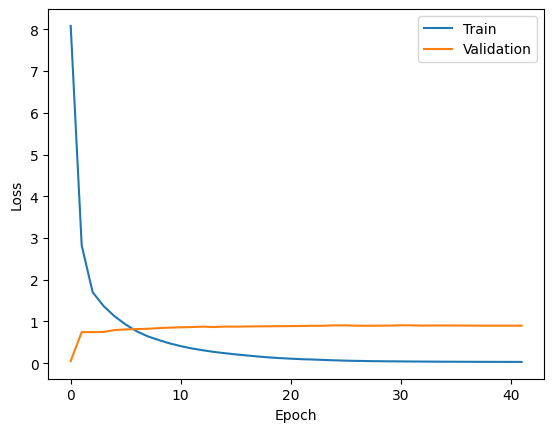

In [79]:
#####################################################################################
# TODO: Train your favorite model and evaluate your model with the test data
#training 2 models FCNN and a LSTM
#i am training a fully connected neural network here
from sklearn.neural_network import MLPClassifier
import matplotlib.pyplot as plt

onehot = preprocessing.OneHotEncoder()
y_train = onehot.fit_transform(intent_train.values.reshape(-1,1))
y_test = onehot.transform(intent_test.values.reshape(-1,1))

# create an MLP classifier hidden layers
model = MLPClassifier(hidden_layer_sizes=(500,100,30,17),max_iter=100, alpha=0.01, learning_rate_init=0.001, solver='adam', random_state=42, validation_fraction =0.1,early_stopping=True)

# fit the model to the training data
model.fit(x_train, y_train)

# evaluate the model on the test data and obtain the test loss
test_acc = model.score(x_test, y_test)
print('Final accuracy: {:.2f}%'.format(test_acc * 100))

train_loss = model.loss_curve_
val_loss = model.validation_scores_

# plot the loss curves
plt.plot(train_loss, label='Train')
plt.plot(val_loss, label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [13]:
############ using glove and then LSTM #############
import gensim.downloader as api
# Load the pre-trained model
model2 = api.load("glove-wiki-gigaword-300")


In [14]:
#vectorizing the queries 
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
import re

nltk.download('punkt')
nltk.download('stopwords')

stemmer = SnowballStemmer('english')
stop_words = set(stopwords.words('english'))
word_list = model2.index_to_key

def preprocess(token):
    # Lowercase the tokens
    tokens = token.lower()
    # Stem the tokens
    tokens = re.sub(r'[^\w\s]', '', tokens)
    return tokens


queries = []
for idx in range(len(query_train)):
  subqueries = query_train[idx].split(" ")
  vec = []
  for num in subqueries:
    pre_num = preprocess(num)
    if num !="BOS" and num != "EOS" and pre_num in word_list:
      vec.append(model2[pre_num])
  queries.append(vec)

tests = []
for idx in range(len(query_test)):
  subqueries = query_test[idx].split(" ")
  vec = []
  for num in subqueries:
    pre_num = preprocess(num)
    if num !="BOS" and num != "EOS" and pre_num in word_list:
      vec.append(model2[pre_num])
  tests.append(vec)


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


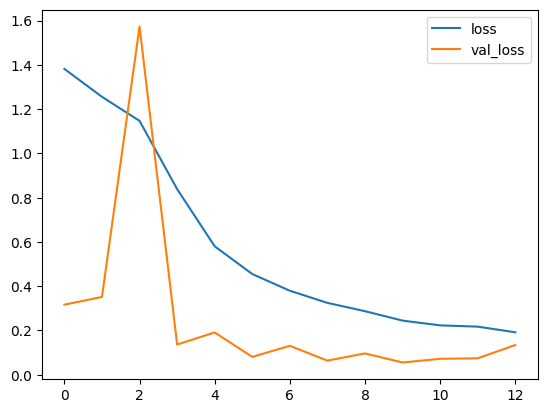


Epoch 13: val_loss did not improve from 0.05535
121/121 [==============================] - 26s 212ms/step - loss: 0.1918 - accuracy: 0.9571 - val_loss: 0.1339 - val_accuracy: 0.9813
Epoch 13: early stopping
19/19 [==============================] - 2s 56ms/step - loss: 0.2641 - accuracy: 0.9334
Test Loss: 0.26414304971694946
Test Accuracy: 0.9334471225738525


In [72]:
#building a LSTM model
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.models import Sequential, load_model
from keras.layers import Embedding, LSTM, Dense, Dropout
import numpy as np
from IPython.display import clear_output
import matplotlib.pyplot as plt
from keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from keras.regularizers import l1, l2
from keras.callbacks import ModelCheckpoint

y_train = labelEncoder.fit_transform(intent_train)
y_test = labelEncoder.transform(intent_test)

# Define the maximum length of the input sequence
max_length = 50

sequence = queries
# Pad the sequences to ensure they all have the same length
padded_sequences = pad_sequences(sequence, maxlen=max_length)

# Define the number of output classes
num_classes = len(set(intent_train))
print(num_classes)
y_train_encoded = to_categorical(y_train, num_classes=num_classes)

# Define the model architecture
model = Sequential()
model.add(LSTM(128,return_sequences=True, input_shape=(50, 300)))
model.add(Dropout(0.50))
model.add(LSTM(32,return_sequences=False))
model.add(Dropout(0.25))
model.add(Dense(17, activation='softmax'))

# Compile the model
model.compile(loss='CategoricalCrossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

print(padded_sequences.shape)
print(len(y_train))

class PlotLoss(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        self.fig = plt.figure()
        self.logs = []
        
    def on_epoch_end(self, epoch, logs={}):
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.i += 1
        clear_output(wait=True)
        plt.plot(self.x, self.losses, label="loss")
        plt.plot(self.x, self.val_losses, label="val_loss")
        plt.legend()
        plt.show()
        
plot_loss = PlotLoss()
early_stop = EarlyStopping(monitor='val_loss', patience=3, verbose=1)

checkpoint_filepath = 'best_model.h5'
# Define the callback to save only the best model based on validation loss
checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=False,
    verbose=1
)


# Train the model
history = model.fit(np.array(padded_sequences), np.array(y_train_encoded), validation_split=0.1, epochs=15, batch_size=32, callbacks=[plot_loss, early_stop,checkpoint_callback])

sequence = tests
# Pad the sequences to ensure they all have the same length
padded_sequences = pad_sequences(sequence, maxlen=max_length)
y_test_encoded = to_categorical(y_test, num_classes=num_classes)

best_model = load_model(checkpoint_filepath)
test_loss, test_acc = best_model.evaluate(np.array(padded_sequences), np.array(y_test_encoded))
print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)


Conclusion:

I initially started with FCNN and i was not expecting great results because context of the words was missing. Surprisingly with a deep enough model, i was able to achieve 92% accuracy.

I was very excited to build a LSTM using word2vec pretrained embedding model.
But I was realized that all the stopwords were missing from the keys which I wasnt comfortable with as stopwords add meaning to statement and we are trying to categorize the statements. So i moved to glove-300 pre trained model. LSTM model can easily get overfitted if we increase the parameters is what i observed. Initially model gave around 90% accuracy and I wasnt happy with it.
So, i went on to add LSTM layers but then model was overfitting and accuracy dropped to 70%. I added dropout layers and L1, L2 layers but L1,L2 layers didnt help. After few tweaks and reducing learning rate and complexity of the model, along with increasing the dropout %, i was able to achieve 93.5% accuracy.
Honestly, I thought LSTM will deliver higher 90s accuracy.
LSTM is Definity the way to go, especially if the vocabulary size increases.

